In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# coding=utf-8
from __future__ import absolute_import, division, print_function

import logging
import argparse
import os
import random
import numpy as np
import time

from datetime import timedelta

import torch
import torch.distributed as dist

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from apex import amp
from apex.parallel import DistributedDataParallel as DDP

from models.modeling import VisionTransformer, CONFIGS
from utils.scheduler import WarmupLinearSchedule, WarmupCosineSchedule
from utils.data_utils import get_loader
from utils.dist_util import get_world_size

from PIL import Image
from sklearn.metrics import classification_report
import pickle

from torchvision import transforms
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler

from utils.dataset import CUB, CarsDataset, NABirds, dogs, INat2017
from utils.autoaugment import AutoAugImageNetPolicy

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def reduce_mean(tensor, nprocs):
    rt = tensor.clone()
    #dist.all_reduce(rt, op=dist.ReduceOp.SUM)
    rt /= nprocs
    return rt

def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu") 

/home/sw01635/anaconda3/envs/transFG/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# setup
model_type = 'ViT-B_16'
name = 'serif_' + model_type.split('-')[-1] + '_long_checkpoint.bin'
pretrained_dir = os.path.join('./pretrained_ViT', model_type + '.npz')
pretrained_model = os.path.join('./output', name)
dataset = 'CUB_200_2011_test'
isTrain = False

# fixed params
data_root = 'dataset'
split = 'overlap'
slide_step = 12
num_classes = 4
img_size = 448
smoothing_value = 0.0
local_rank = -1
data_root = '{}/{}'.format(data_root, dataset)
train_batch_size = 4
eval_batch_size = 16
nprocs = 1

In [5]:
def get_accuracy(model, test_loader):

    eval_losses = AverageMeter()
    model.eval()
    all_preds, all_label = [], []

    epoch_iterator = tqdm(test_loader,
                          desc="Validating... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()

    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits = model(x)

            eval_loss = loss_fct(logits, y)
            eval_loss = eval_loss.mean()
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Validating... (loss=%2.5f)" % eval_losses.val)

    all_preds_1, all_label_1 = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds_1, all_label_1)
    accuracy = torch.tensor(accuracy).to(device)

    val_accuracy = reduce_mean(accuracy, nprocs)
    val_accuracy = val_accuracy.detach().cpu().numpy()

    return val_accuracy, all_preds_1, all_label_1

In [6]:
# Prepare model
config = CONFIGS[model_type]
config.split = split
config.slide_step = slide_step

model = VisionTransformer(config, img_size, zero_head=True, num_classes=num_classes,
                          smoothing_value=smoothing_value)

model.load_from(np.load(pretrained_dir))

if pretrained_model is not None:
    pretrained_model = torch.load(pretrained_model)['model']
    model.load_state_dict(pretrained_model)
model.to(device);

load_pretrained: resized variant: torch.Size([1, 197, 768]) to torch.Size([1, 1370, 768])
load_pretrained: grid-size from 14 to 37


In [7]:
test_transform=transforms.Compose([transforms.Resize((600, 600), Image.BILINEAR),
                                   transforms.CenterCrop((448, 448)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

testset = CUB(root=data_root, is_train=isTrain, transform=test_transform)
test_sampler = SequentialSampler(testset) if local_rank == -1 else DistributedSampler(testset)

test_loader = DataLoader(testset,
                         sampler=test_sampler,
                         batch_size=eval_batch_size,
                         num_workers=4,
                         pin_memory=True) if testset is not None else None

In [8]:
acc, preds, labels = get_accuracy(model, test_loader)

out = dict()
out['acc'] = acc
out['preds'] = preds
out['labels'] = labels

save_obj(out, 'TransFG_' + model_type)

Validating... (loss=1.03026): 100%|| 105/105 [02:27<00:00,  1.41s/it]


In [29]:
CLASSES = ['linear', 'slab', 'sans', 'triangular']

images = np.array(testset.test_img)

error_indicator = preds != labels
error_examples = images[error_indicator, :, :]

(178, 500, 500)


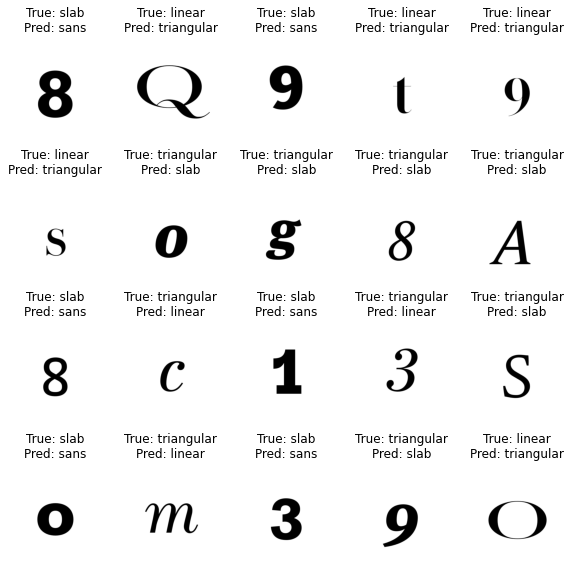

In [54]:
cols = 5 # Number of columns
rows = 4 # Number of rows

# grab the samples from the training set
samples_index = np.random.choice(list(range(error_examples.shape[0])), cols*rows, replace =False)
samples = error_examples[samples_index]
labels_true = labels[error_indicator][samples_index]
labels_pred = preds[error_indicator][samples_index]

fig = plt.figure(figsize=(2 * cols, 2 * (rows+1)))

i = 0

# Add subplot for each image
for col in range(cols):
    for row in range(rows):

        ax = fig.add_subplot(rows, cols, col * rows + row + 1) # Add a sub-plot at (row, col)
        ax.grid(b=False) # Get rid of the grids
        ax.axis("off") # Get rid of the axis
        ax.imshow(samples[i, :]) # Show random image
        ax.set_title('True: '+CLASSES[labels_true[i]]+'\nPred: '+CLASSES[labels_pred[i]]) # Set title of the sub-plot
        
        i = i + 1
plt.savefig('TransFG_' + model_type + '.png')

In [35]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       558
           1       0.89      0.88      0.89       496
           2       0.00      0.00      0.00         0
           3       0.95      0.86      0.90       620

    accuracy                           0.89      1674
   macro avg       0.70      0.67      0.68      1674
weighted avg       0.93      0.89      0.91      1674



/home/sw01635/anaconda3/envs/transFG/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sw01635/anaconda3/envs/transFG/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sw01635/anaconda3/envs/transFG/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
